In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy as np
from nuance import Nuance
from tinygp import kernels, GaussianProcess

df = pd.read_csv("../data/lightcurves/P1.4736842105263157_R1.92_1411.8866757062847.csv")
time, flux, error = df.values.T
t_0 = time[0]
time -= t_0

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


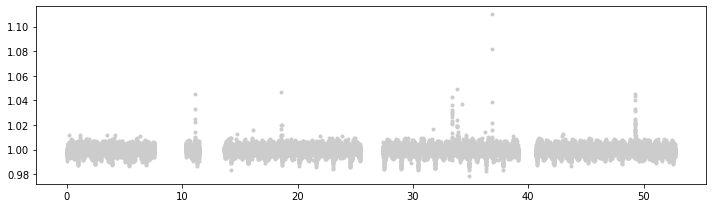

In [2]:
plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")
plt.tight_layout()

# Design matrix

In [3]:
X = time**np.arange(0, 3)[:, None]
X[1::] -= X[1::].mean(1)[:, None]
X[1::] /= X[1::].std(1)[:, None]

# GP

In [4]:
from tinygp import kernels, GaussianProcess
import yaml

params = yaml.full_load(open("../data/gp.yaml", "r"))

kernel = kernels.quasisep.SHO(
    omega=params["omega"], 
    quality=params["quality"], 
    sigma=params["sigma"]
) 
    
gp = GaussianProcess(kernel, time, diag=params["jitter"]**2, mean=1.)

# Sigclip

In [5]:
import jax

def mu(self, mask=None):
    if mask is None:
        mask = mask = np.ones_like(self.x).astype(bool)

    masked_x = self.x[mask]
    masked_y = self.y[mask]
    masked_X = self.X[:, mask]
    
    @jax.jit
    def _mu():
        gp = self.gp
        _, w, _ = self.eval_m(np.zeros_like(self.x))
        w = w[0:-1]
        cond_gp = gp.condition(self.y - w@self.X, self.x).gp
        return cond_gp.loc + w@self.X

    return _mu()

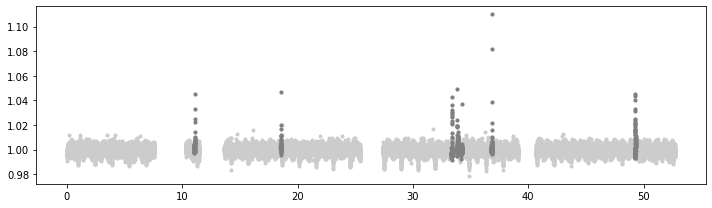

In [6]:
nu = Nuance(time, flux, gp, X)

mask = np.ones_like(time).astype(bool)
mask_down = np.ones_like(time).astype(bool)
window = 30

for i in range(3):
    if i == 0:
        m = np.mean(flux)
    else:
        m = mu(nu, mask)
    r = (flux - m)
    mask_up = np.array(r < np.std(r[mask])*1.5)
    #mask_down = np.array(r > - np.std(r[mask])*1.5)

    # mask around flares
    ups = np.flatnonzero(~mask_up)
    if len(ups) > 0:
        mask_up[np.hstack([np.arange(max(u-window, 0), min(u+window, len(nu.x))) for u in ups])] = False
    mask = np.logical_and(mask_up, mask_down)
    
plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time[~mask], flux[~mask], ".", c="0.5")
plt.tight_layout()

# Linear search

In [7]:
from nuance import Nuance
from tinygp import kernels, GaussianProcess

gp = GaussianProcess(kernel, time[mask], diag=params["jitter"]**2, mean=0.)
nu = Nuance(time[mask], flux[mask], gp, X[:, mask])

t0s = time.copy()
Ds = np.linspace(0.01, 0.1, 10)
result = nu.linear_search(t0s, Ds)

  0%|          | 0/31564 [00:00<?, ?it/s]

In [233]:
from tinygp import kernels

In [238]:
subclass(kernels.Exp())

NameError: name 'subclass' is not defined

# Periodic search 1

In [8]:
searches = []
search = result.copy()
periods = np.linspace(.9, 5., 5000)

In [9]:
search = nu.periodic_search(search,  periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [10]:
def binn(x, y, n):
    N = int(len(x)/n)
    ns = np.histogram(x, N)[0]
    bx = np.histogram(x, N, weights=x)[0]/ns
    by = np.histogram(x, N, weights=y)[0]/ns
    return bx, by

(-0.03259599581360817, 0.03259599581360817)

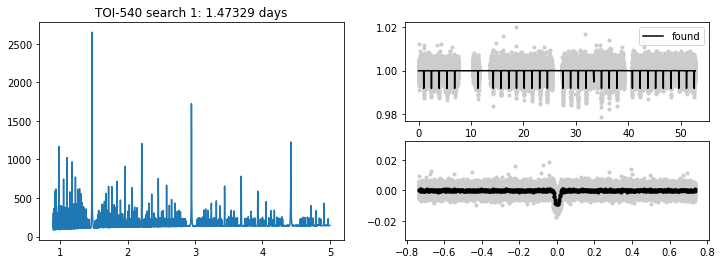

In [101]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search.best

plt.subplot(2, 2, (1, 3))
plt.plot(*search.periodogram())
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu.x, nu.y, ".", c="0.8")
plt.plot(nu.x, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu.models(t0, D, P)
phi = phase(nu.x, t0, P)
detrended = nu.y - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

# Search 2

In [12]:
from nuance.utils import phase

def mask(self, t0, D, P):
    new_search = self.copy()
    new_search.llc = None
    new_search.llv = None
    ph = phase(self.t0s, t0, P)
    m = np.abs(ph) < 2*D
    new_search.ll[m] = self.ll0.copy()
    return new_search

In [13]:
search2 = mask(search, t0, D, P)

## Periodic search 2

In [14]:
search2 = nu.periodic_search(search2, periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

(-0.005019674077630043, 0.005019674077630043)

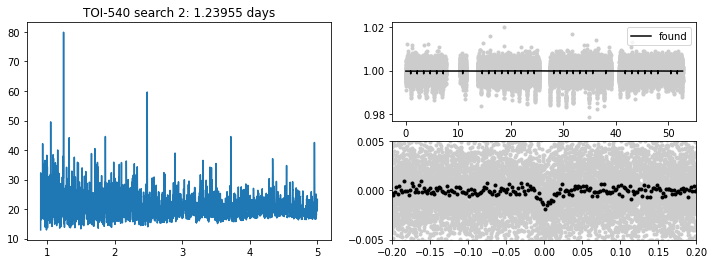

In [100]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search2.best

plt.subplot(2, 2, (1, 3))
plt.plot(*search2.periodogram())
plt.title(f"TOI-540 search 2: {P:.5f} days")

mean, astro, noise = nu.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu.x, nu.y, ".", c="0.8")
plt.plot(nu.x, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu.models(t0, D, P)
phi = phase(nu.x, t0, P)
detrended = nu.y - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

# Search 3

In [43]:
search3 = mask(search2, t0, D, P)

## Periodic search 2

In [44]:
search3 = nu.periodic_search(search3, periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

(-0.0037939015310257673, 0.0037939015310257673)

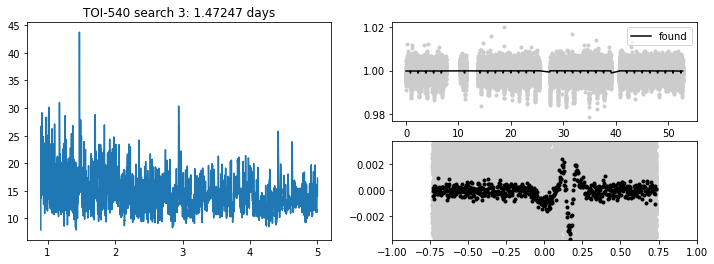

In [102]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search3.best

plt.subplot(2, 2, (1, 3))
plt.plot(*search3.periodogram())
plt.title(f"TOI-540 search 3: {P:.5f} days")

mean, astro, noise = nu.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu.x, nu.y, ".", c="0.8")
plt.plot(nu.x, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu.models(t0, D, P)
phi = phase(nu.x, t0, P)
detrended = nu.y - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

# Explore results

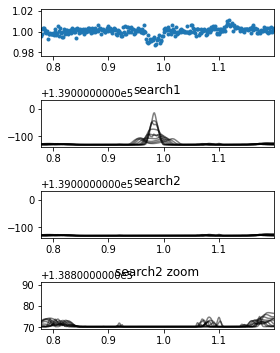

In [207]:
t0, D, P = search.best
#t0 += 9*P
xlim = (t0 + np.array([-1, 1])*7*D)

plt.figure(figsize=(4, 5))
plt.subplot(411)
plt.plot(nu.x, nu.y, ".")
plt.xlim(*xlim)

plt.subplot(412)
plt.plot(search.t0s, search.ll, c="k", alpha=0.5)
plt.xlim(*xlim)
ylim = plt.ylim()
plt.title("search1")

plt.subplot(413)
plt.title("search2")
plt.plot(search2.t0s, search2.ll, c="k", alpha=0.5)
plt.xlim(*xlim)
plt.ylim(ylim)

plt.subplot(414)
plt.title("search2 zoom")
plt.plot(search2.t0s, search2.ll, c="k", alpha=0.5)
plt.xlim(*xlim)

plt.tight_layout()

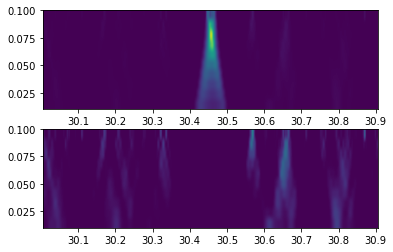

In [217]:
from scipy.interpolate import interp2d

t0, D, P = search.best
t0 += 20*P
xlim = (t0 + np.array([-1, 1])*15*D)
x = np.arange(nu.x.min(), nu.x.max(), 0.001)

plt.subplot(211)
fll = interp2d(search.Ds, search.t0s, search.ll)
plt.imshow(fll(search.Ds, x).T, aspect='auto', extent=(x.min(), x.max(), search.Ds.min(), search.Ds.max()), vmin=search.ll0)
_ = plt.xlim(*xlim)

plt.subplot(212)
fll = interp2d(search.Ds, search.t0s, search2.ll)
plt.imshow(fll(search.Ds, x).T, aspect='auto', extent=(x.min(), x.max(), search.Ds.min(), search.Ds.max()), vmin=search.ll0)
_ = plt.xlim(*xlim)

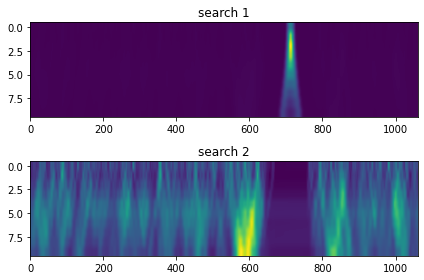

In [232]:
t0, D, P = search.best
plt.subplot(211)
plt.imshow(search.fold(P)[1].T, aspect='auto')
plt.title("search 1")
plt.subplot(212)
plt.imshow(search2.fold(P)[1].T, aspect='auto')
plt.title("search 2")
plt.tight_layout()

In [171]:
nu.x

array([0.00000000e+00, 1.38891894e-03, 2.77783788e-03, ...,
       5.27419320e+01, 5.27433209e+01, 5.27447098e+01])

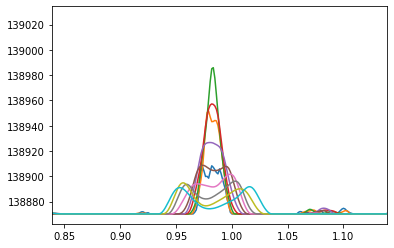

In [172]:
plt.plot(search.t0s, search.ll)
_ = plt.xlim(*xlim)

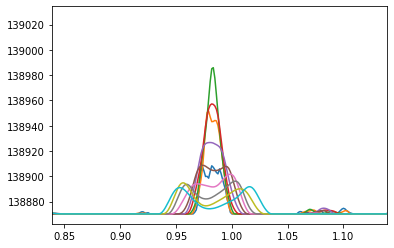

In [174]:
plt.plot(nu.x, fll(search.Ds, nu.x))
_ = plt.xlim(*xlim)

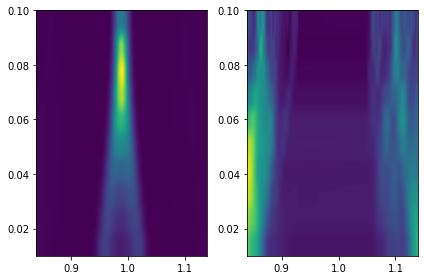

In [150]:
t0, D, P = search.best
xlim = (t0 + np.array([-1, 1])*5*D)

plt.subplot(121)
a, b, _ = search.in(P)
plt.imshow(b.T, aspect='auto', extent=(a.min()*P, a.max()*P, search.Ds.min(), search.Ds.max()))
_ = plt.xlim(*xlim)

plt.subplot(122)
a, b, _ = search2.fold(P)
plt.imshow(b.T, aspect='auto', extent=(a.min()*P, a.max()*P, search.Ds.min(), search.Ds.max()))
_ = plt.xlim(*xlim)
plt.tight_layout()

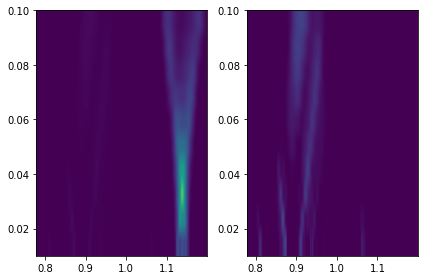

In [126]:
plt.subplot(121)
search.show_ll()
_ = plt.xlim(*xlim)

plt.subplot(122)
search2.show_ll()
_ = plt.xlim(*xlim)

plt.tight_layout()